In [1]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
from torch.optim import Adam
import torch.nn.functional as F
from torchinfo import summary
import transformers
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix
import kagglehub
import pandas as pd
import numpy as np
import math
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from pathlib import Path
import itertools
from peft import LoraConfig, get_peft_model
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
import nltk

## Configurations and preprocessing

In [2]:
torch.set_printoptions(threshold=1000)
pd.set_option("display.max_colwidth", 1000)

Set manual random seed for reproducibility.

In [3]:
RANDOM_SEED = 42
torch.manual_seed(RANDOM_SEED)
torch.mps.manual_seed(RANDOM_SEED)

In [4]:
MODELS_BASEDIR = Path("saved-models")
DEVICE = torch.device("mps" if torch.mps.is_available() else "cpu")
DEVICE.type

'mps'

Load data. Source: https://www.kaggle.com/datasets/artemminiailo/medicalconversations2disease

In [5]:
path = Path(kagglehub.dataset_download("artemminiailo/medicalconversations2disease")) / "medical_conversations.csv"
medical_df = pd.read_csv(path, names=('text', 'label'), skiprows=1)
medical_df.head()

,text,label
0,"User: I’ve been sneezing a lot today and my nose feels congested. </s> Bot: That sounds like it could be an allergy. Do you know what might be triggering it? </s> User: I’m not sure. Maybe pollen? </s> Bot: Pollen is a common allergen. Have you had any other symptoms, like itchy eyes or a sore throat? </s> User: Yes, my eyes are itchy too. </s> Bot: Sounds like classic hay fever. Over-the-counter antihistamines could help relieve the symptoms. </s>",allergy
1,"User: I’ve developed a rash after eating some strawberries. </s> Bot: That could be an allergic reaction. Have you had strawberries before without any issues? </s> User: Yes, but this time I ate a lot of them. </s> Bot: It could be a food allergy. If the rash worsens or if you have difficulty breathing, it’s important to seek medical attention immediately. </s>",allergy
2,"User: My eyes are swollen and itchy, and I can’t stop sneezing. </s> Bot: That could be an allergy, possibly triggered by dust or pollen. Do you have a history of allergies? </s> User: Yes, I usually get allergies in the spring. </s> Bot: Spring allergies are often due to pollen. You might want to take an antihistamine to help with the symptoms. </s>",allergy
3,User: I’ve been getting headaches and a stuffy nose for a few days. </s> Bot: Do you think it might be an allergy or possibly a cold? </s> User: I think it’s allergies because I’ve been around pets a lot. </s> Bot: Pet allergies are common. You could try using allergy medication to relieve your symptoms. </s>,allergy
4,"User: Every time I eat nuts, my mouth itches. </s> Bot: That sounds like a food allergy. Have you ever had a more severe reaction? </s> User: No, it’s just the itching. </s> Bot: It might still be a good idea to avoid nuts, especially if you start experiencing more serious symptoms, like swelling or difficulty breathing. </s>",allergy


Add example conversations about non-medical topics labeled as 'none', meaning no disease is discussed. Prevents the chat bot from overfitting to the medical topics. The conversations are generated with Chat GPT.

In [6]:
with open("non_medical_conversations.txt", "r") as f:
    lines = f.readlines()

non_medical_df = pd.DataFrame({'text': [line.strip() for line in lines], 'label': 'none'})
non_medical_df.head()

,text,label
0,User: Hello there! </s> Bot: Hello! How can I assist you today? </s> User: Just wanted to say hi. </s> Bot: Hi! I'm here to help with any medical-related questions you might have. </s>,none
1,"User: What's your favorite color? </s> Bot: I'm a medical chatbot, so I don't have personal preferences. How can I assist you with your health concerns? </s>",none
2,"User: Tell me a joke. </s> Bot: I'm here to help with medical questions, but I hope your day is filled with laughter and good health! </s>",none
3,User: How's the weather today? </s> Bot: I'm not equipped to provide weather updates. Do you have any medical questions I can assist with? </s>,none
4,"User: Can you help me with math homework? </s> Bot: I specialize in medical advice. For math, you might want to ask another AI or a tutor. How can I help with your health? </s>",none


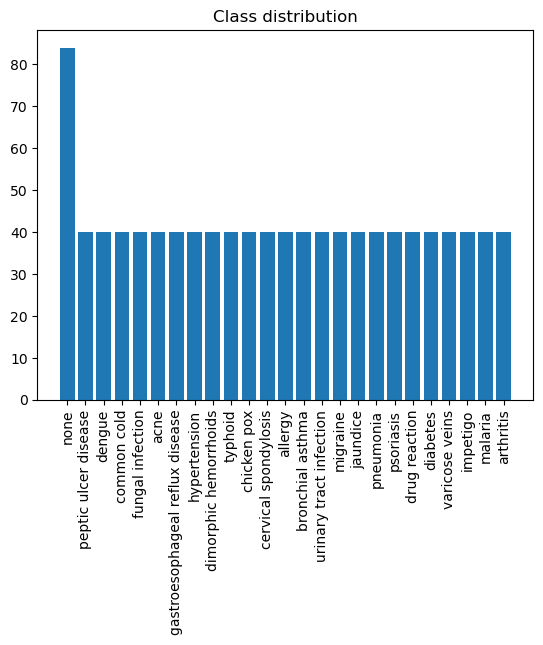

In [7]:
df = pd.concat([medical_df, non_medical_df], ignore_index=True)
class_counts = df['label'].value_counts().to_dict()
plt.bar(class_counts.keys(), class_counts.values())
plt.xticks(rotation=90)
plt.title('Class distribution')
plt.show()

In [8]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mikael.lenander/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

Word cloud.

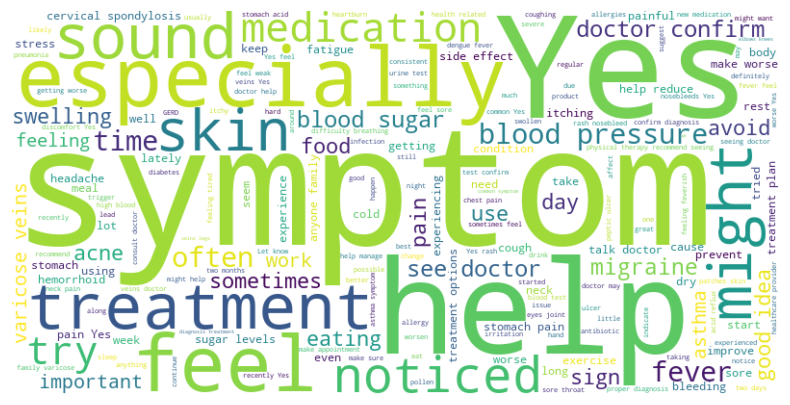

In [9]:
text = ' '.join(df['text'])

words = word_tokenize(text)
stop_words = set(stopwords.words('english')) | {'/s', 'user', 'bot'}
filtered_words = [word for word in words if word.lower() not in stop_words]
filtered_text = ' '.join(filtered_words)

wordcloud = WordCloud(width=800, height=400, background_color='white', colormap='viridis').generate(filtered_text)

plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.show()

In [10]:
def test_train_split(df, train_size):
    train_df = df.groupby('label', group_keys=False).apply(lambda x: x.sample(frac=train_size, random_state=RANDOM_SEED))
    test_df = df.drop(train_df.index)
    return train_df, test_df

In [11]:
def save_model(model: nn.Module, model_name):
    MODELS_BASEDIR.mkdir(parents=True, exist_ok=True)
    model_save_path = MODELS_BASEDIR / model_name
    print(f"Saving model to: {model_save_path}")
    torch.save(obj=model.state_dict(), f=model_save_path)

In [12]:
TRAIN_SIZE = 0.9
train_df, test_df = test_train_split(df, TRAIN_SIZE)

## Text classifier

The objective of the text classifier is to predict the disease label based on the conversation text.

Load pretrained BERT model and tokenizer.

In [13]:
CLASSIIER_BASE_MODEL_NAME = 'bert-base-uncased'
CLASSIFIER_FILE = "bert-disease-predictor2.pt"
bert = transformers.BertModel.from_pretrained(CLASSIIER_BASE_MODEL_NAME).to(DEVICE)
classifier_tokenizer = transformers.BertTokenizer.from_pretrained(CLASSIIER_BASE_MODEL_NAME)

Custom dataset for tokenized text.

In [14]:
class LabeledText(Dataset):
    def __init__(self, df, tokenizer):
        self.tokens = tokenizer(df['text'].tolist(), padding=True, truncation=True, return_tensors='pt').to(DEVICE)
        self.label_encoder = LabelEncoder()
        self.labels = torch.tensor(self.label_encoder.fit_transform(df['label'])).to(DEVICE)
        self.classes = self.label_encoder.classes_
    
    def __len__(self):
        return len(self.tokens['input_ids'])

    def __getitem__(self, index):
        return (self.tokens['input_ids'][index], self.tokens['token_type_ids'][index], self.tokens['attention_mask'][index]), self.labels[index]

In [15]:
class BertClassifier(nn.Module):
    def __init__(self, bert, num_classes):
        super(BertClassifier, self).__init__()
        self.bert = bert
        for param in self.bert.parameters():
            param.requires_grad = False
        self.dropout = nn.Dropout(0.1)
        self.output = nn.Linear(in_features=self.bert.pooler.dense.out_features, out_features=num_classes, bias=True)
    
    def forward(self, input_ids, token_type_ids, attention_mask):
        x = self.bert(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_mask)['pooler_output']
        x = self.dropout(x)
        x = self.output(x)
        return x

Stop training when the validation loss stops decreasing:

In [16]:
class EarlyStopper:
    def __init__(self, patience=1, min_delta=0):
        self.patience = patience
        self.min_delta = min_delta
        self.counter = 0
        self.min_validation_loss = float("inf")

    def early_stop(self, validation_loss):
        if validation_loss < self.min_validation_loss:
            self.min_validation_loss = validation_loss
            self.counter = 0
        elif validation_loss > (self.min_validation_loss + self.min_delta):
            self.counter += 1
            print('Patience left:', self.patience - self.counter)
            if self.counter >= self.patience:
                return True
        return False

In [17]:
def train_step(model, loader, loss_fn, optimizer, set_size):
    model.train()
    total_loss, total_correct = 0, 0
    for i, ((input_ids, token_type_ids, attention_masks), y) in enumerate(loader):
        print(f"Batch {i+1}/{len(loader)}", end="\r")
        y_pred = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks)
        loss = loss_fn(y_pred, y)
        total_loss += loss.item()
        total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    
    train_loss = total_loss / len(loader)
    train_accuracy = total_correct / set_size
    print()
    print(f"Train loss: {train_loss:.4f} | Train accuracy: {train_accuracy:.4f}")

    return train_loss, train_accuracy


def test_step(model, loader, loss_fn, set_size):
    model.eval()
    total_loss, total_correct = 0, 0

    with torch.inference_mode():
        for (input_ids, token_type_ids, attention_masks), y in loader:
            y_pred = model(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks)
            loss = loss_fn(y_pred, y)
            total_loss += loss.item()
            total_correct += torch.sum(y_pred.argmax(dim=1) == y).item()
        
        test_loss = total_loss / len(loader)
        test_accuracy = total_correct / set_size
        print(f"Test loss: {test_loss:.4f} | Test accuracy: {test_accuracy:.4f}")

    return test_loss, test_accuracy

Split into training and validation sets.

In [18]:
BATCH_SIZE = 32

classifier_train_set = LabeledText(train_df, classifier_tokenizer)
classifier_test_set = LabeledText(test_df, classifier_tokenizer)

train_loader = DataLoader(classifier_train_set, batch_size=BATCH_SIZE)
test_loader = DataLoader(classifier_test_set, batch_size=BATCH_SIZE, shuffle=False)

In [19]:
classifier = BertClassifier(bert, len(classifier_train_set.classes)).to(DEVICE)
optimizer = Adam(classifier.parameters(), lr=1e-4)
loss_fn = nn.CrossEntropyLoss()
early_stopper = EarlyStopper(patience=20)

summary(classifier)

Layer (type:depth-idx)                                       Param #
BertClassifier                                               --
├─BertModel: 1-1                                             --
│    └─BertEmbeddings: 2-1                                   --
│    │    └─Embedding: 3-1                                   (23,440,896)
│    │    └─Embedding: 3-2                                   (393,216)
│    │    └─Embedding: 3-3                                   (1,536)
│    │    └─LayerNorm: 3-4                                   (1,536)
│    │    └─Dropout: 3-5                                     --
│    └─BertEncoder: 2-2                                      --
│    │    └─ModuleList: 3-6                                  (85,054,464)
│    └─BertPooler: 2-3                                       --
│    │    └─Linear: 3-7                                      (590,592)
│    │    └─Tanh: 3-8                                        --
├─Dropout: 1-2                                         

In [ ]:
EPOCHS = 2000
metrics = {"train_loss": [], "train_accuracy": [], "test_loss": [], "test_accuracy": []}

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}\n-------------------------------")
    train_loss, train_accuracy = train_step(classifier, train_loader, loss_fn, optimizer, len(classifier_train_set))
    test_loss, test_accuracy = test_step(classifier, test_loader, loss_fn, len(classifier_test_set))

    metrics["train_loss"].append(train_loss)
    metrics["train_accuracy"].append(train_accuracy)
    metrics["test_loss"].append(test_loss)
    metrics["test_accuracy"].append(test_accuracy)

    if early_stopper.early_stop(test_loss):
        print("Early stopping")
        break

    if epoch % 5 == 0:
        save_model(classifier, CLASSIFIER_FILE)

Epoch 1
-------------------------------
Batch 30/30
Train loss: 3.5059 | Train accuracy: 0.0255
Test loss: 3.2351 | Test accuracy: 0.0481
Epoch 2
-------------------------------
Batch 30/30
Train loss: 3.3097 | Train accuracy: 0.0383
Test loss: 3.1568 | Test accuracy: 0.0577
Epoch 3
-------------------------------
Batch 30/30
Train loss: 3.2686 | Train accuracy: 0.0511
Test loss: 3.1053 | Test accuracy: 0.0962
Epoch 4
-------------------------------
Batch 30/30
Train loss: 3.2529 | Train accuracy: 0.0755
Test loss: 3.0705 | Test accuracy: 0.0865
Epoch 5
-------------------------------
Batch 30/30
Train loss: 3.2342 | Train accuracy: 0.0819
Test loss: 3.0442 | Test accuracy: 0.0865
Saving model to: saved-models/bert-disease-predictor2.pt
Epoch 6
-------------------------------
Batch 30/30
Train loss: 3.2192 | Train accuracy: 0.0819
Test loss: 3.0226 | Test accuracy: 0.0865
Epoch 7
-------------------------------
Batch 30/30
Train loss: 3.2095 | Train accuracy: 0.0809
Test loss: 3.0054 |

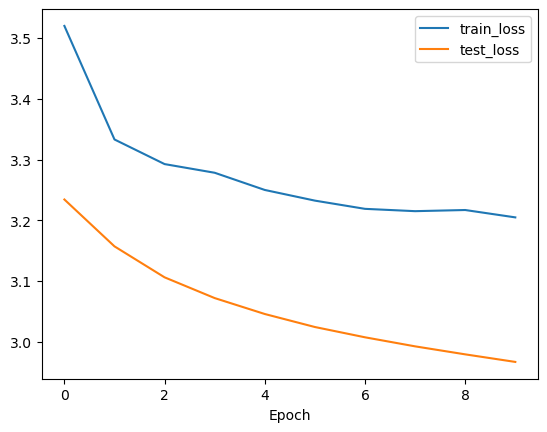

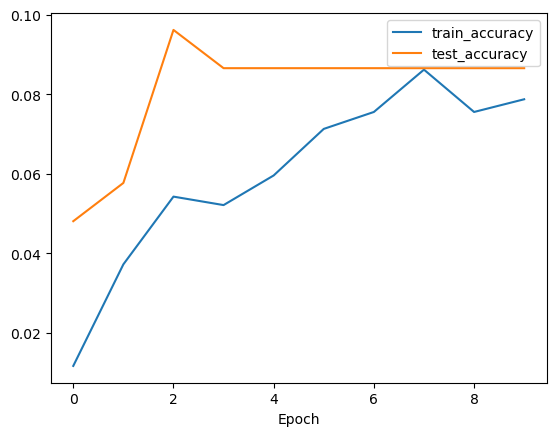

In [ ]:
def plot_training_metrics(keys, metrics):
    for key in keys:
        plt.plot(metrics[key], label=key)
    plt.legend()
    plt.xlabel("Epoch")
    plt.show()

plot_training_metrics(["train_loss", "test_loss"], metrics)
plot_training_metrics(["train_accuracy", "test_accuracy"], metrics)

Load model for inference.

In [20]:
classifier.load_state_dict(torch.load(MODELS_BASEDIR / CLASSIFIER_FILE, weights_only=True))

<All keys matched successfully>

Calculate test accuracy.

In [ ]:
predicted_labels = []

classifier.eval()
total_loss, total_correct = 0, 0

with torch.inference_mode():
    for (input_ids, token_type_ids, attention_masks), y in test_loader:
        output = classifier(input_ids=input_ids, token_type_ids=token_type_ids, attention_mask=attention_masks)
        y_pred = output.argmax(dim=1)
        predicted_labels.extend(y_pred.tolist())

predicted_labels = torch.tensor(predicted_labels)
true_labels = classifier_test_set.labels.cpu()
test_accuracy = sum(predicted_labels == true_labels) / len(classifier_test_set.labels)
print(f"Test accuracy: {test_accuracy:.4f}")

Test accuracy: 0.0865


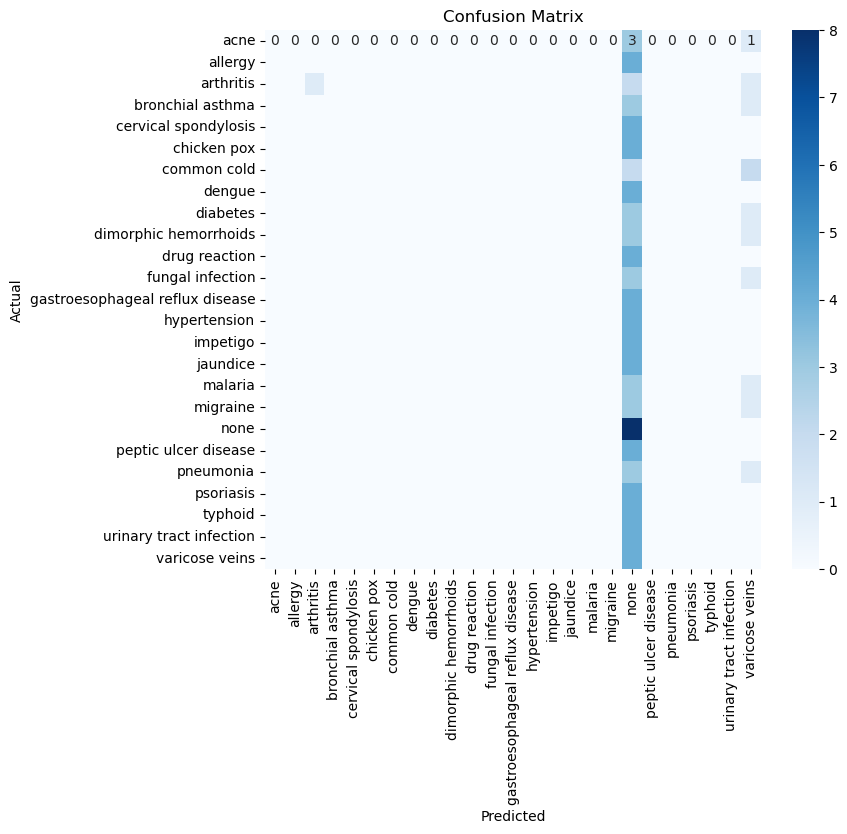

In [ ]:
conf_matrix = confusion_matrix(true_labels, predicted_labels)

plt.figure(figsize=(8, 7))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=classifier_test_set.classes, yticklabels=classifier_test_set.classes)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Chat bot

The objective of the chat bot is to provide a conversational interface for the text classifier. The chat bot will ask questions from the patient and tries to understand the patient's symptoms.

In [137]:
CHATBOT_BASE_MODEL_NAME = "Qwen/Qwen2-0.5B-Instruct"
CHATBOT_FILE = "chatbot.pt"
chatbot = transformers.AutoModelForCausalLM.from_pretrained(
    CHATBOT_BASE_MODEL_NAME,
    torch_dtype="auto",
    device_map="auto",
).to(DEVICE)
chatbot_tokenizer = transformers.AutoTokenizer.from_pretrained(CHATBOT_BASE_MODEL_NAME, padding_side="left", truncation=True)
chatbot_tokenizer.pad_token = '<|endoftext|>'

summary(chatbot)

Convert conversations from text format to list of dictionaries (chat templates). If the user and bot have multiple turns, multiple templates are created from one conversation by including 1, ..., n turns to the template.

In [138]:
SYSTEM_MESSAGE = {
    "role": "system",
    "content": "You are an empathetic doctor chatbot. If a user describes symptoms, you try to make a diagnosis by asking clarifying questions about the symptoms. You may also give short suggestions for treatment. If the user talks about something else, you say that you only discuss medical issues. You keep your answers short.",
}

def generate_template(conversation):
    roles = {"user": "user", "bot": "assistant"}
    lines = conversation.split("</s>")
    template = [SYSTEM_MESSAGE]
    for line in lines:
        sep_idx = line.find(":")
        if sep_idx == -1:
            continue
        message = {
            "role": roles[line[:sep_idx].lower().strip()],
            "content": line[sep_idx + 1:].strip(),
        }
        template.append(message)
    templates = []
    for i, message in enumerate(template):
        if message["role"] == "assistant":
            templates.append(template[:i+1])
    return templates

Convert chat templates to token IDs. The label is the last comment of the bot. 

In [139]:
def generate_training_data(chat_templates):
    inputs_tokenized = chatbot_tokenizer.apply_chat_template(chat_templates, padding=True, return_tensors="pt")
    inputs_left_shifted = inputs_tokenized[:, :-1]

    attention_mask = torch.where(inputs_left_shifted != chatbot_tokenizer.pad_token_id, 1, 0)

    im_start_token = chatbot_tokenizer.additional_special_tokens[0]
    label_templates = [template[-1] for template in chat_templates]
    label_texts = [f'\n{im_start_token}assistant\n{template["content"]}{chatbot_tokenizer.eos_token}\n' for template in label_templates]
    labels_tokenized = chatbot_tokenizer(
        label_texts,
        padding="max_length",
        max_length=inputs_tokenized.shape[1],
        return_tensors="pt"
    )["input_ids"]
    labels_fixed = torch.where(labels_tokenized != chatbot_tokenizer.pad_token_id, labels_tokenized, -100)
    labels_right_shifted = labels_fixed[:, 1:]

    return {
        'input_ids': inputs_left_shifted.to(DEVICE),
        'attention_mask': attention_mask.to(DEVICE),
        'labels': labels_right_shifted.to(DEVICE)
    }

Custom dataset for tokenized chat templates.

In [140]:
class Conversations(Dataset):
    def __init__(self, df):
        self.chat_templates = list(itertools.chain(*map(generate_template, df['text']))) # chain flattens 2d list to 1d
        self.sequences = generate_training_data(self.chat_templates)
    
    def __len__(self):
        return len(self.sequences['input_ids'])
    
    def __getitem__(self, idx):
        return (self.sequences['input_ids'][idx], self.sequences['attention_mask'][idx]), self.sequences['labels'][idx]

In [141]:
def calculate_loss(logits, labels):
    loss_fn = nn.CrossEntropyLoss()
    return loss_fn(logits.view(-1, logits.size(-1)), labels.view(-1))

In [ ]:
lora_config = LoraConfig(
    task_type="CAUSAL_LM",
    r=16,
    lora_alpha=16,
    lora_dropout=0.3,
    target_modules=['q_proj', 'v_proj']
)
chatbot = get_peft_model(chatbot, lora_config)
chatbot.print_trainable_parameters()

trainable params: 1,081,344 || all params: 495,114,112 || trainable%: 0.2184


In [143]:
BATCH_SIZE = 8
bot_train_set, bot_test_set = Conversations(train_df), Conversations(test_df)
train_loader = DataLoader(bot_train_set, batch_size=BATCH_SIZE, shuffle=True)
optimizer = Adam(chatbot.parameters(), lr=1e-4)

Gradient accumulation is used due to hardware limitations.

In [ ]:
ACCUMULATION_STEPS = 2
EPOCHS = 2
losses = np.zeros(EPOCHS)

for epoch in range(1, EPOCHS + 1):
    print(f"Epoch {epoch}/{EPOCHS}\n-------------------------------")
    chatbot.train()
    total_loss = 0
    for i, ((input_ids, attention_masks), labels) in enumerate(train_loader):
        print(f'Batch {i+1}/{len(train_loader)}', end='\r')
        outputs = chatbot(input_ids=input_ids, attention_mask=attention_masks)
        loss = calculate_loss(outputs.logits, labels) / ACCUMULATION_STEPS
        total_loss += loss.item()

        loss.backward()

        if i % ACCUMULATION_STEPS == 0:
            optimizer.step()
            optimizer.zero_grad()
        
    torch.cuda.empty_cache()
    
    train_loss = total_loss / len(train_loader)
    losses[epoch - 1] = train_loss
    print()
    print(f"Train loss: {train_loss:.4f}")

    save_model(chatbot, CHATBOT_FILE)


Epoch 1/2
-------------------------------
Batch 341/341
Train loss: 0.6626
Saving model to: saved-models/chatbot.pt
Epoch 2/2
-------------------------------
Batch 341/341
Train loss: 0.5868
Saving model to: saved-models/chatbot.pt


Test the model with some test prompts.

In [ ]:
chatbot.eval()
num_samples = 3
idxs = np.random.randint(0, len(bot_test_set), size=num_samples)
samples = bot_test_set[idxs]
labels = samples[1]
input_ids = samples[0][0]
for i in range(num_samples):
    last_turn_start_id = torch.where(labels[i] == -100)[0][-1] + 5
    input_id = input_ids[i, :last_turn_start_id].unsqueeze(0)
    attention_mask = torch.ones(input_id.shape).to(DEVICE)
    with torch.inference_mode():
        generated_ids = chatbot.generate(
            input_ids=input_id,
            attention_mask=attention_mask,
            max_new_tokens=100,
        )[0][input_id.shape[1]:]
        print('PROMPT:', chatbot_tokenizer.batch_decode(input_id, skip_special_tokens=False)[0])
        print('RESPONSE:', ''.join(chatbot_tokenizer.batch_decode(generated_ids, skip_special_tokens=False)))
        print()

PROMPT: <|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|endoftext|><|en

Interactive medical chat bot demo.

In [163]:
template = [SYSTEM_MESSAGE]
classifier_input = ''
prompt = input("User: ")

while prompt.lower() != "done":
    print(f"User: {prompt}")
    template.append({"role": "user", "content": prompt})
    classifier_input += f"User: {prompt} </s> "
    input_ids = chatbot_tokenizer.apply_chat_template(template, add_generation_prompt=True, return_tensors="pt").to(DEVICE)
    attention_mask = torch.ones(input_ids.shape).to(DEVICE)
    with torch.inference_mode():
        generated_ids = chatbot.generate(
            input_ids=input_ids,
            attention_mask=attention_mask,
            max_new_tokens=50,
        )[0][input_ids.shape[1]:]
    generated_ids = generated_ids
    response = chatbot_tokenizer.decode(generated_ids, skip_special_tokens=True)
    print(f"DoctorAI: {response}")
    template.append({"role": "assistant", "content": response})
    classifier_input += f"Bot: {response} </s> "
    prompt = input("User: ")

if len(template) > 1:
    tokens = classifier_tokenizer(classifier_input, return_tensors="pt").to(DEVICE)
    with torch.inference_mode():
        logits = classifier(
            input_ids=tokens["input_ids"],
            attention_mask=tokens["attention_mask"],
            token_type_ids=tokens["token_type_ids"],
        )
        output = F.softmax(logits, dim=1).squeeze()
        prediction = torch.argmax(output).item()
        disease = classifier_test_set.classes[prediction]
        confidence = output[prediction].item()
        print(f"Disease: {disease} (confidence: {confidence:.4f})")

User: I have been experiencing a bad headache after taking my medication.
DoctorAI: Great! I'd be happy to help. What's your prescription or dosage of medication?
User: It is blood pressure medication
DoctorAI: Blood pressure medications can cause headaches. Do you have any specific questions about this side effect?
User: SYSTEM_MESSAGE
DoctorAI: I'm sorry to hear about your headache. It sounds like it could be related to your blood pressure medication. Is there anything in particular you're concerned about with your medication?
User: 
DoctorAI: Your medication might contain certain ingredients that can affect your blood pressure levels. Could you please provide more details on which medications you're currently taking and what the specific ingredient(s) are? This information will help me better understand how this affects your health.


KeyboardInterrupt: Interrupted by user